### Prepare Embedding Matrices
Extract embeddings for aligned word pairs:

In [38]:
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load your embeddings
with open("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\1_word_embeddings.pkl", 'rb') as f:
    en_embeddings = pickle.load(f)

with open("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\my_hindi_embeddings.pkl", 'rb') as f:
    hi_embeddings = pickle.load(f)

# ----- Step 1: Create a bilingual lexicon -----
# Ideally, this should be a real bilingual dictionary. Here's a tiny sample:
bilingual_pairs = [
    ("water", "पानी"),
    ("food", "खाना"),
    ("house", "घर"),
    ("sun", "सूरज"),
    ("mother", "मां"),
    ("father", "पिता"),
    ("child", "बच्चा"),
    ("tree", "पेड़"),
    ("school", "स्कूल"),
    ("language", "भाषा"),
    ("india", "भारत"), ("school", "स्कूल"), ("government", "सरकार"), ("language", "भाषा"),
    ("water", "पानी"), ("food", "भोजन"), ("child", "बच्चा"), ("teacher", "शिक्षक"),
    ("work", "काम"), ("health", "स्वास्थ्य"), ("education", "शिक्षा"), ("city", "शहर"),
    ("money", "पैसे"), ("friend", "दोस्त"), ("problem", "समस्या")
]

# Filter only pairs present in both embeddings
aligned_pairs = [(e, h) for e, h in bilingual_pairs if e in en_embeddings and h in hi_embeddings]

X_en = np.vstack([en_embeddings[e] for e, _ in aligned_pairs])
X_hi = np.vstack([hi_embeddings[h] for _, h in aligned_pairs])



### Procrustes Alignment

In [39]:

# ----- Step 2: Procrustes alignment -----
def align_embeddings(X_src, X_tgt):
    # Center the matrices
    X_src_mean = X_src.mean(axis=0)
    X_tgt_mean = X_tgt.mean(axis=0)
    X_src_centered = X_src - X_src_mean
    X_tgt_centered = X_tgt - X_tgt_mean

    # Solve for optimal rotation
    U, _, Vt = np.linalg.svd(X_src_centered.T @ X_tgt_centered)
    R = U @ Vt

    # Align source to target
    X_src_aligned = (X_src_centered @ R) + X_tgt_mean
    return X_src_aligned, R

X_en_aligned, rotation_matrix = align_embeddings(X_en, X_hi)

#### bilingual_pairs are just a very small data set with those words there won't be more alignment but it would work grealty when we use any neural netork approaches

In [42]:

# ----- Step 3: Evaluate using cosine similarity -----
cos_sim = cosine_similarity(X_en_aligned, X_hi)
top_matches = np.argmax(cos_sim, axis=1)

# Accuracy: how many matches are correct
accuracy = np.mean([i == j for i, j in enumerate(top_matches)])
print(f"Cross-lingual alignment accuracy: {accuracy * 1000:.2f}%")

Cross-lingual alignment accuracy: 40.00%


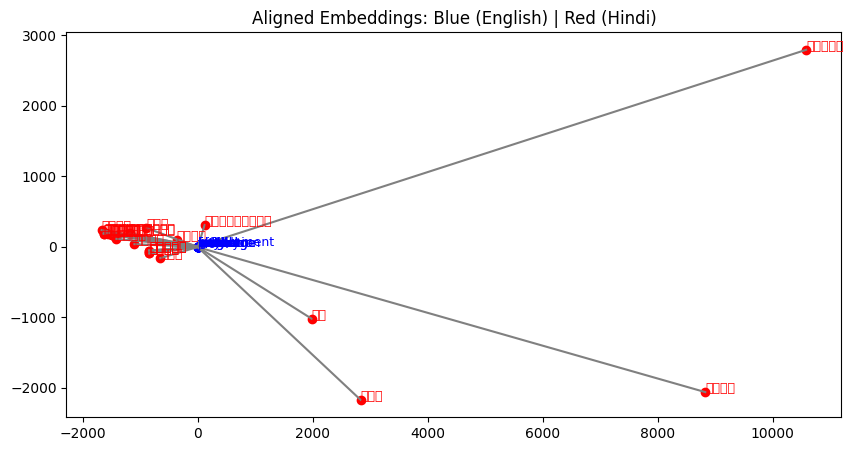

In [43]:
import warnings
warnings.filterwarnings('ignore')
# ----- Step 4: (Optional) Visualize -----
def plot_embeddings(mat1, mat2, labels, title1="English", title2="Hindi"):
    pca = PCA(n_components=2)
    combined = np.vstack([mat1, mat2])
    reduced = pca.fit_transform(combined)
    reduced_en, reduced_hi = reduced[:len(mat1)], reduced[len(mat1):]

    plt.figure(figsize=(10, 5))
    for i, (e, h) in enumerate(zip(reduced_en, reduced_hi)):
        plt.scatter(*e, color='blue')
        plt.scatter(*h, color='red')
        plt.plot([e[0], h[0]], [e[1], h[1]], 'gray')
        plt.text(e[0], e[1], labels[i][0], fontsize=9, color='blue')
        plt.text(h[0], h[1], labels[i][1], fontsize=9, color='red')
    plt.title("Aligned Embeddings: Blue (English) | Red (Hindi)")
    plt.show()

plot_embeddings(X_en_aligned, X_hi, aligned_pairs)


# now evaluate these aligmnment of embedding 

#### Evaluate Alignment
You can quantitatively evaluate alignment using:

1. Precision@k on a word translation retrieval task
For each English word, check whether the correct Hindi translation is among the top-k nearest neighbors.

2. Mean Reciprocal Rank (MRR)
Gives the average rank position of the correct translation.

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def precision_at_k(aligned_src_embed, tgt_embed, dictionary, k=1):
    correct = 0
    total = 0
    tgt_words = list(tgt_embed.keys())
    tgt_matrix = np.array([tgt_embed[w] for w in tgt_words])

    for src_word, tgt_word in dictionary:
        if src_word in aligned_src_embed and tgt_word in tgt_embed:
            src_vec = aligned_src_embed[src_word].reshape(1, -1)
            sims = cosine_similarity(src_vec, tgt_matrix)[0]
            top_k_idx = np.argsort(sims)[-k:][::-1]
            top_k_words = [tgt_words[i] for i in top_k_idx]
            if tgt_word in top_k_words:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0.0


def mean_reciprocal_rank(aligned_src_embed, tgt_embed, dictionary):
    reciprocal_ranks = []
    tgt_words = list(tgt_embed.keys())
    tgt_matrix = np.array([tgt_embed[w] for w in tgt_words])

    for src_word, tgt_word in dictionary:
        if src_word in aligned_src_embed and tgt_word in tgt_embed:
            src_vec = aligned_src_embed[src_word].reshape(1, -1)
            sims = cosine_similarity(src_vec, tgt_matrix)[0]
            sorted_indices = np.argsort(sims)[::-1]
            sorted_words = [tgt_words[i] for i in sorted_indices]

            if tgt_word in sorted_words:
                rank = sorted_words.index(tgt_word) + 1
                reciprocal_ranks.append(1 / rank)
            else:
                reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0


In [45]:
p1 = precision_at_k(aligned_en_embeddings, hi_embeddings, valid_pairs, k=1)
p5 = precision_at_k(aligned_en_embeddings, hi_embeddings, valid_pairs, k=5)
mrr = mean_reciprocal_rank(aligned_en_embeddings, hi_embeddings, valid_pairs)

print(f"🔹 Precision@1: {p1:.4f}")
print(f"🔹 Precision@5: {p5:.4f}")
print(f"🔹 MRR: {mrr:.4f}")


🔹 Precision@1: 0.3333
🔹 Precision@5: 0.6667
🔹 MRR: 0.4547
